In [1]:
import pandas as pd
import numpy as np

btc_prices = pd.read_csv('/Users/dimmehal/PycharmProjects/twitter_sentiment/data/btc_prices.csv')


In [2]:
def process_price_timeseries(btc_prices, start_date, end_date, window):
    btc_prices['open_time'] = pd.to_datetime(btc_prices['open_time'], format='%Y-%m-%d %H:%M:%S')
    btc_prices_2 = btc_prices.resample('60min', on='open_time').mean()
    btc_ts = btc_prices[
        (btc_prices['open_time'] > pd.to_datetime(start_date)) & (btc_prices['open_time'] < pd.to_datetime(end_date))]

    # drop and resample every day
    btc_ts.reset_index().drop('index', axis=1)
    btc_ts_2 = btc_ts.resample('D', on='open_time').mean()
    #btc_ts_2['price'] = btc_ts_2['open'].rolling(window=5).mean()
    btc_ts_2['price'] = btc_ts_2['open']


    # delta function
    btc_ts_2['delta'] = btc_ts_2['price'] - btc_ts_2['open'].shift(-1)

    # clear up
    ts = btc_ts_2.reset_index()
    ts['id'] = ts.index
    ts = ts[['id', 'price', 'open_time']]
    return ts


def find_minima_maxima(ts):
    from scipy.signal import argrelextrema
    import numpy as np
    n = 5

    ts['min'] = ts.iloc[argrelextrema(ts.price.values, np.less_equal,
                                      order=n)[0]]['price']
    ts['max'] = ts.iloc[argrelextrema(ts.price.values, np.greater_equal,
                                      order=n)[0]]['price']


def simplify_and_correct(ts):
    ts_corrected = ts.fillna(ts.iloc[4].price)
    ts = ts_corrected.set_index('open_time').drop(columns=['id', 'min', 'max'])
    ts = ts.price.apply(lambda x: np.log2(x + 1))

In [260]:
ts = process_price_timeseries(btc_prices, '2021-01-01', '2021-09-30', 'd')

In [267]:
ts['price'] = ts['price'].rolling(window=5).mean()


In [272]:
ts = ts.fillna(ts.price[4])
ts_class = ts

In [262]:
ts = ts.drop(columns='id')
ts = ts.set_index(keys=['open_time'])

In [5]:
ts = np.log(ts) - 10
ts

,price
open_time,
2021-01-01,0.282354
2021-01-02,0.331811
2021-01-03,0.417758
2021-01-04,0.368067
2021-01-05,0.380381
...,...
2021-08-02,0.586452
2021-08-03,0.557333
2021-08-04,0.563998


In [6]:

import matplotlib.pyplot as plt
import datetime
import numpy as np
from matplotlib.pyplot import figure


def create_plot(x, y):
    plt.plot(x,y)
    plt.show()


In [89]:
delta = ts['price'].shift(-1) - ts['price']

In [90]:
import numpy as np

mean = delta.mean()
sd = np.sqrt(delta.var())

In [91]:
delta = delta.to_frame()
delta['delta'] = delta['price']
delta['price'] = ts['price']


In [92]:
delta

,price,delta
open_time,,
2021-01-01,0.282354,0.049457
2021-01-02,0.331811,0.085947
2021-01-03,0.417758,-0.049691
2021-01-04,0.368067,0.012314
2021-01-05,0.380381,0.076979
...,...,...
2021-08-02,0.586452,-0.029119
2021-08-03,0.557333,0.006665
2021-08-04,0.563998,0.018022


In [93]:
def classify_change(x,mean, sd, n):
    if  np.abs(x.delta - mean) > n*sd:
        return x.price
    else:
        return np.nan
    
def classify_type(x):
    if x.delta > 0 and not np.isnan(x.heavy):
        return x.price
    else:
        return np.nan
    
def classify_type_fall(x):
    if x.delta < 0 and not np.isnan(x.heavy):
        return x.price
    else:
        return np.nan

delta['heavy'] = delta.apply(lambda x: classify_change(x, mean, sd, 1.5), axis=1)
delta['super_heavy'] = delta.apply(lambda x: classify_change(x, mean, sd, 2.5), axis=1)

In [94]:
delta_rise = delta.copy()
delta_fall = delta.copy()
delta_rise['heavy'] = delta.apply(classify_type, axis=1)
delta_fall['heavy'] = delta.apply(classify_type_fall, axis=1)


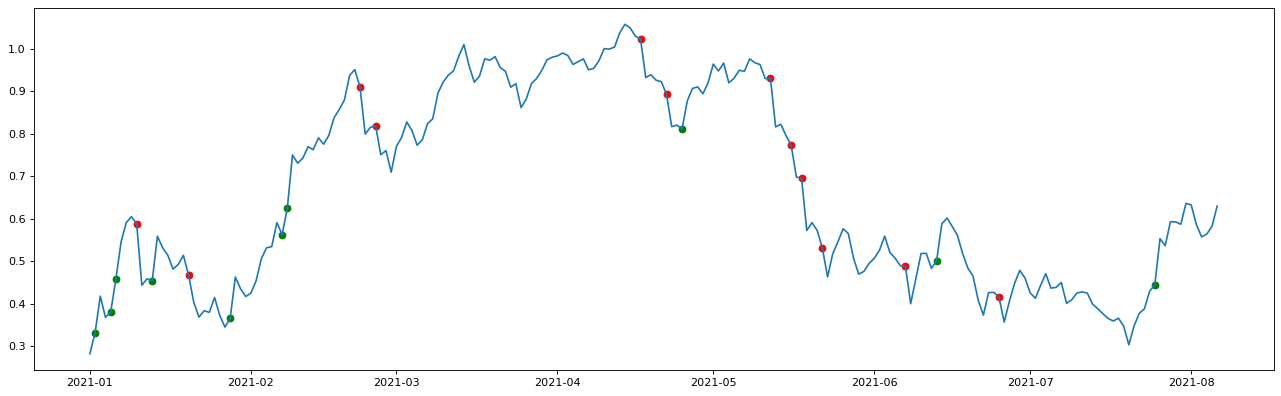

In [97]:
figure(figsize=(20, 6), dpi=80)
plt.scatter(ts.index, delta_rise['heavy'], c='g')
plt.scatter(ts.index, delta_fall['heavy'], c='r')
create_plot(ts.index, ts.price)

In [98]:
heavy_dates = delta[pd.notnull(delta['heavy'])].index.tolist()

In [99]:
# def extract_user(user_object):
#     return user_object['name']

# def extract_follower_count(user_object):
#     return user_object['followers_count']

# all_tweets['username'] = all_tweets['user'].apply(extract_user)
# all_tweets['follower_count'] = all_tweets['user'].apply(extract_follower_count)

In [100]:
all_tweets = pd.read_csv('/Users/dimmehal/PycharmProjects/twitter_sentiment/data/btc_tweets_processed_sent.csv')

/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [154]:
def parse_date(tweet_sentiments, name='date'):
    tweet_sentiments[name] = pd.to_datetime(tweet_sentiments[name], format='%Y-%m-%d %H:%M:%S', errors='coerce')
    tweet_sentiments.sort_values(by=[name])

    # plt.plot(tweet_sentiments['compound'])
    tweet_sentiments

    tweet_sentiments.shape

    tweet_sentiments[name] = pd.to_datetime(tweet_sentiments[name], format='%Y-%m-%d %H:%M:%S', errors='coerce')

    tweet_sentiments = tweet_sentiments[tweet_sentiments[name].apply(lambda x: x != pd.NaT)]

    tweet_sentiments.sort_values(by=[name])

    return tweet_sentiments

all_tweets = parse_date(all_tweets, 'created_at')

In [115]:
#all_tweets.to_csv('/Users/dimmehal/PycharmProjects/twitter_sentiment/data/btc_tweets_processed_sent.csv')


In [116]:
# Now we look at each individual date as a coarsing limit

all_tweets['created_at'] = all_tweets['created_at'].apply(lambda x: x.floor('D'))
all_tweets

,Unnamed: 0,Unnamed: 0.1,created_at,id,id_str,text,truncated,entities,extended_entities,source,...,quoted_status,withheld_in_countries,withheld_scope,withheld_copyright,username,follower_count,neg,neu,pos,compound
0,0,0,2021-12-17,1471717656558374912,1.471718e+18,"Wright Brothers at Kitty Hawk on December 17, ...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1471717598110781440, 'id_str...","<a href=""https://mobile.twitter.com"" rel=""nofo...",...,NaN,NaN,NaN,NaN,Bitcoin,4033143.0,0.000,1.000,0.000,0.0000
1,1,1,2021-12-16,1471610136959488000,1.471610e+18,RT @whale_alert: 💤 A dormant address containin...,False,"{'hashtags': [{'text': 'BTC', 'indices': [52, ...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",...,NaN,NaN,NaN,NaN,Bitcoin,4033143.0,0.122,0.878,0.000,-0.3595
2,2,2,2021-12-16,1471609123137482752,1.471609e+18,San Fran... https://t.co/98jNRuYSqJ,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1471609020968423431, 'id_str...","<a href=""https://mobile.twitter.com"" rel=""nofo...",...,NaN,NaN,NaN,NaN,Bitcoin,4033143.0,0.000,1.000,0.000,0.0000
3,3,3,2021-12-16,1471518901913612292,1.471519e+18,RT @DeribitExchange: Quarterly expiry is growi...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",...,NaN,NaN,NaN,NaN,Bitcoin,4033143.0,0.000,0.952,0.048,0.1779
4,4,4,2021-12-16,1471515115484696577,1.471515e+18,RT @SBF_FTX: We’re excited to announce that FT...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",...,NaN,NaN,NaN,NaN,Bitcoin,4033143.0,0.000,0.912,0.088,0.3400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32956,32956,32956,2021-12-12,1469824665682341890,1.469825e+18,ビットコインの時価総額が高くなると、BTCドミナンスが下がるのはいつもの話。 https:/...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",...,{'created_at': 'Wed Dec 08 22:05:05 +0000 2021...,NaN,NaN,NaN,仮想NISHI,58121.0,0.000,1.000,0.000,0.0000
32957,32957,32957,2021-12-11,1469793016764592129,1.469793e+18,RT @Reihoxy: 完全な信用経済で成り立っているVR界隈に首を突っ込もうとしている法...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",...,NaN,NaN,NaN,NaN,仮想NISHI,58121.0,0.000,1.000,0.000,0.0000
32958,32958,32958,2021-12-11,1469791167827292160,1.469791e+18,CoinPostの最新ニュース、仮想通貨規制派と推進派の，ニュース https://t.co...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 1469791163733331973, 'id_str...","<a href=""http://twitter.com/download/iphone"" r...",...,NaN,NaN,NaN,NaN,仮想NISHI,58121.0,0.000,1.000,0.000,0.0000
32959,32959,32959,2021-12-11,1469789852871065601,1.469790e+18,バーチャル不動産やべぇw\n1.1億円也\n\nhttps://t.co/Wg6gGo3ePf,False,"{'hashtags': [], 'symbols': [], 'user_mentions...",NaN,"<a href=""http://twitter.com/download/iphone"" r...",...,NaN,NaN,NaN,NaN,仮想NISHI,58121.0,0.000,1.000,0.000,0.0000


In [117]:
all_tweets_g = all_tweets.groupby(['username', 'created_at']).agg({"compound":"sum", "follower_count":"max"})

In [118]:
all_tweets_g = all_tweets_g.reset_index()
mean_sentiment = all_tweets_g.groupby(['username']).agg({"compound":"mean"})

In [119]:
all_tweets_g = all_tweets_g.merge(mean_sentiment, left_on='username', right_on='username')

In [120]:
# # compare the datasert with a list of peaks to find out the most influencial
# def compare_with_peaks(tweets, heavy_dates, maxdist=3):
    
#     tweets_filtered = [None for i in range(maxdist)]
#     for i in range(maxdist):
#         heavy_dates = [heavy_dates[i]-np.timedelta64(1, 'D') for i in range(len(heavy_dates))]
#         tweets_filtered = tweets_filtered[]
    

all_tweets_g

,username,created_at,compound_x,follower_count,compound_y
0,Airdrop Inspector,2020-03-31,1.1438,1061109.0,1.832878
1,Airdrop Inspector,2020-04-01,1.5142,1061109.0,1.832878
2,Airdrop Inspector,2020-04-02,0.5719,1061109.0,1.832878
3,Airdrop Inspector,2020-04-03,0.2759,1061109.0,1.832878
4,Airdrop Inspector,2020-04-05,0.5719,1061109.0,1.832878
...,...,...,...,...,...
4487,仮想NISHI,2021-12-12,0.5786,58121.0,0.286633
4488,仮想NISHI,2021-12-13,0.0000,58121.0,0.286633
4489,仮想NISHI,2021-12-14,0.4824,58121.0,0.286633
4490,仮想NISHI,2021-12-15,0.6588,58121.0,0.286633


In [121]:
all_tweets_g

,username,created_at,compound_x,follower_count,compound_y
0,Airdrop Inspector,2020-03-31,1.1438,1061109.0,1.832878
1,Airdrop Inspector,2020-04-01,1.5142,1061109.0,1.832878
2,Airdrop Inspector,2020-04-02,0.5719,1061109.0,1.832878
3,Airdrop Inspector,2020-04-03,0.2759,1061109.0,1.832878
4,Airdrop Inspector,2020-04-05,0.5719,1061109.0,1.832878
...,...,...,...,...,...
4487,仮想NISHI,2021-12-12,0.5786,58121.0,0.286633
4488,仮想NISHI,2021-12-13,0.0000,58121.0,0.286633
4489,仮想NISHI,2021-12-14,0.4824,58121.0,0.286633
4490,仮想NISHI,2021-12-15,0.6588,58121.0,0.286633


In [122]:
heavy_dates_1 = [heavy_dates[i]-np.timedelta64(1, 'D') for i in range(len(heavy_dates))]
heavy_dates_2 = [heavy_dates[i]-np.timedelta64(2, 'D') for i in range(len(heavy_dates))]
heavy_dates_3 = [heavy_dates[i]-np.timedelta64(3, 'D') for i in range(len(heavy_dates))]

heavy_dates_all = heavy_dates_1 + heavy_dates_2 + heavy_dates_3


tweets_filtered = all_tweets_g[all_tweets_g['created_at'].isin(heavy_dates_all)]
tweets_filtered

,username,created_at,compound_x,follower_count,compound_y
144,Airdrop Inspector,2020-12-30,0.5719,1061109.0,1.832878
145,Airdrop Inspector,2021-01-02,0.5719,1061109.0,1.832878
146,Airdrop Inspector,2021-01-03,0.5719,1061109.0,1.832878
147,Airdrop Inspector,2021-01-04,1.0986,1061109.0,1.832878
148,Airdrop Inspector,2021-01-05,0.5719,1061109.0,1.832878
...,...,...,...,...,...
4337,Nazionale Italiana ⭐️⭐️⭐️⭐️,2021-06-23,0.0000,885221.0,0.431959
4338,Nazionale Italiana ⭐️⭐️⭐️⭐️,2021-06-24,0.1027,885221.0,0.431959
4365,Nazionale Italiana ⭐️⭐️⭐️⭐️,2021-07-22,0.3400,885221.0,0.431959
4366,Nazionale Italiana ⭐️⭐️⭐️⭐️,2021-07-23,0.3400,885221.0,0.431959


In [123]:
def find_important_change(row, thresh):
    return abs(row.compound_x - row.compound_y)/row.compound_y > thresh
        

tweets_filtered = tweets_filtered[tweets_filtered.apply(lambda r:find_important_change(r, 2.0) , axis=1)]

In [124]:
list_of_users = tweets_filtered.username.unique()

In [125]:
tweets_filtered.compound_x.max()

12.667899999999998

/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


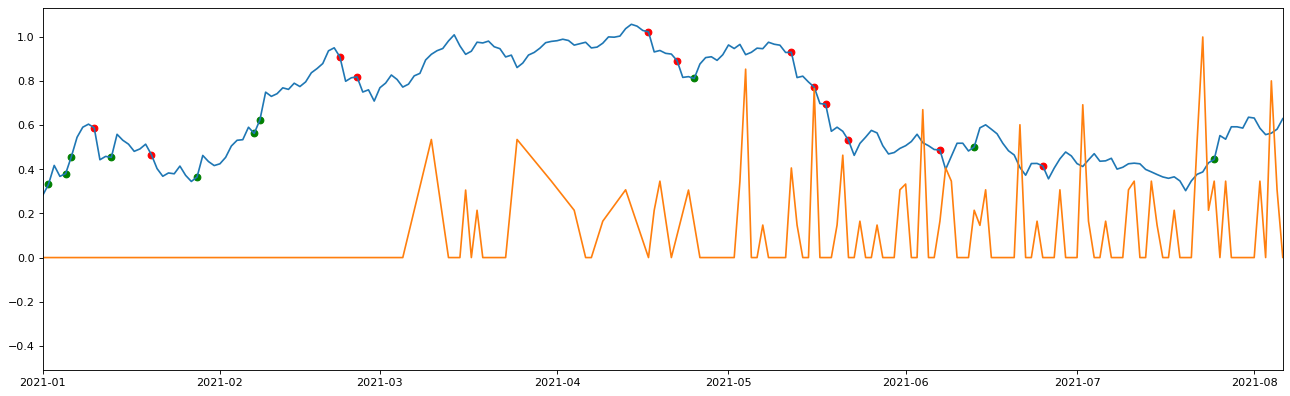

/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


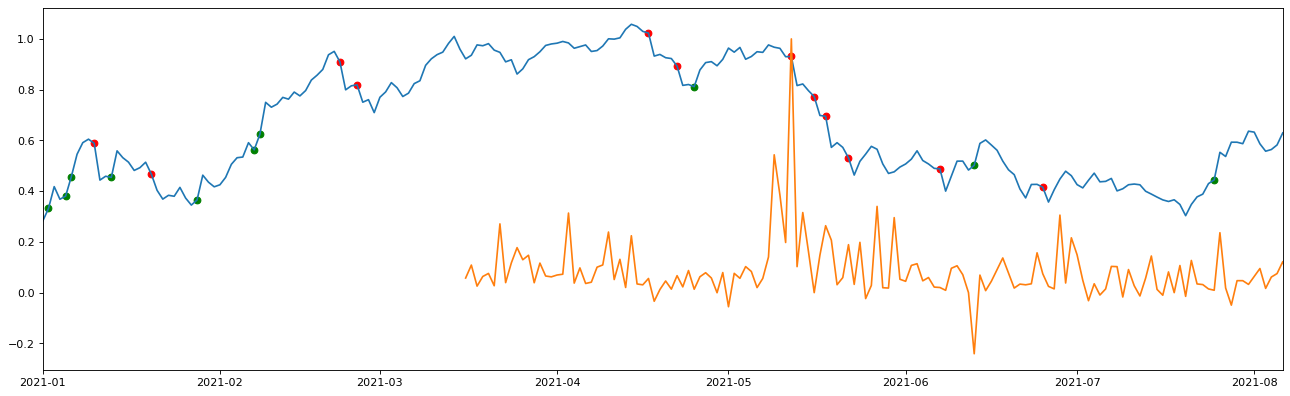

/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


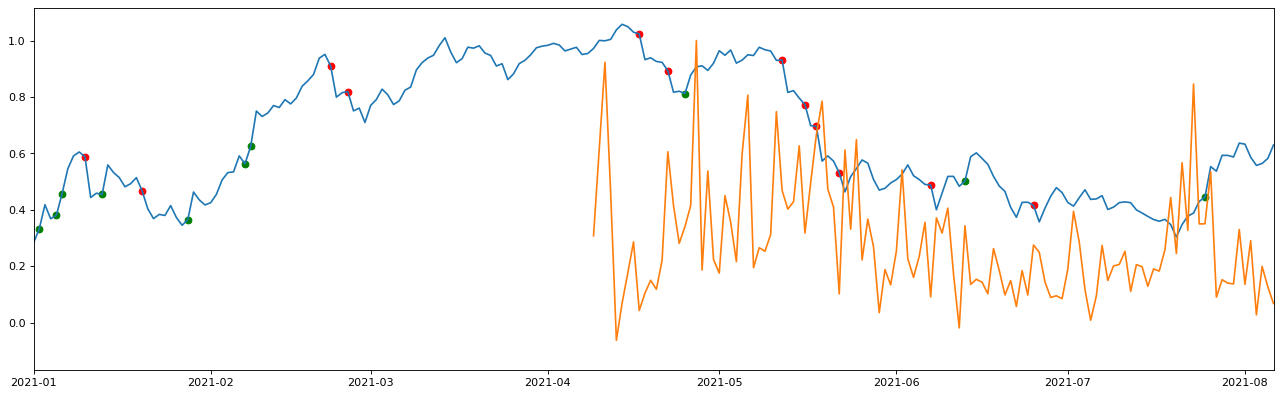

/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


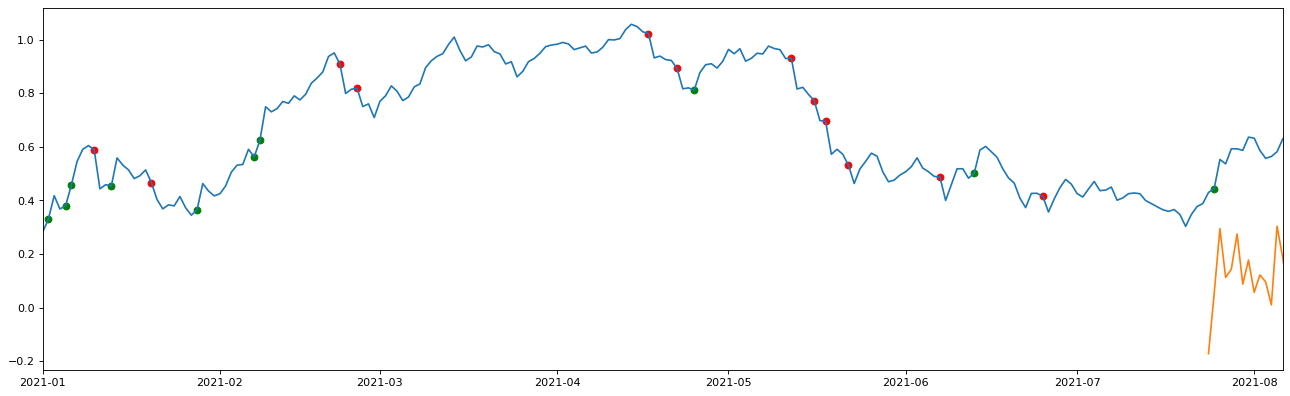

/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


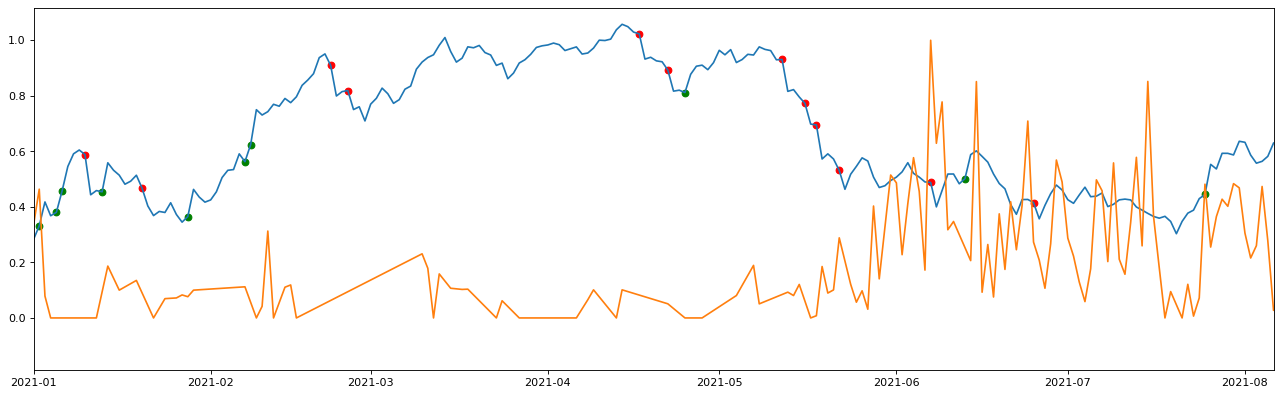

/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


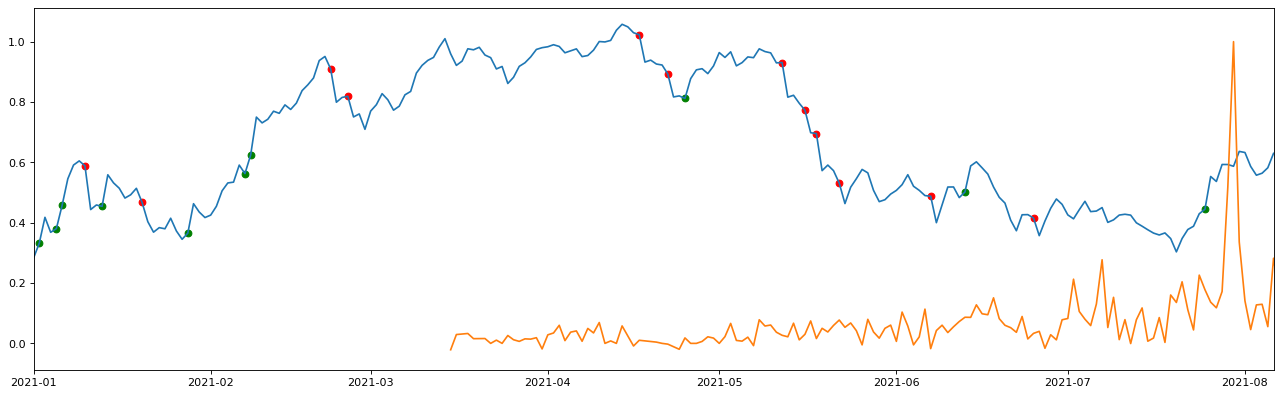

/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


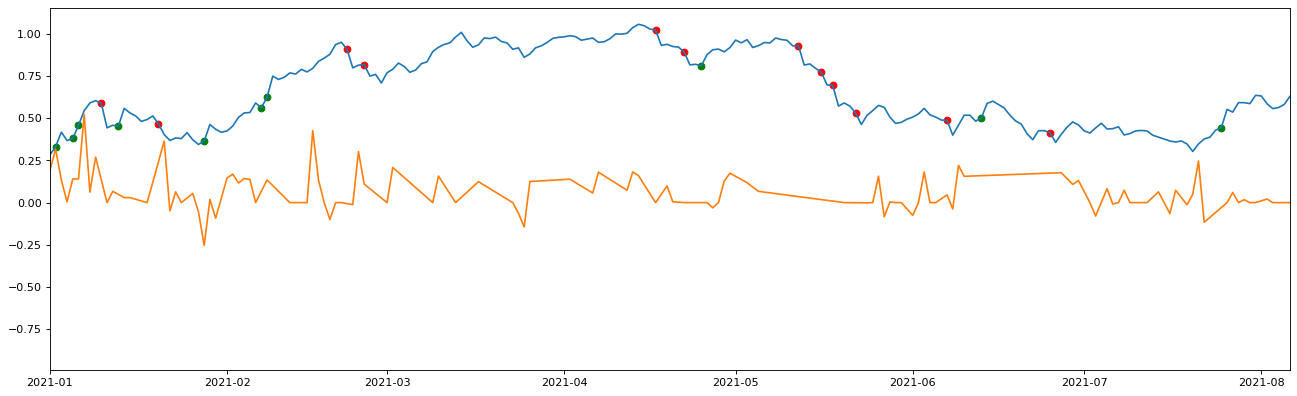

/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


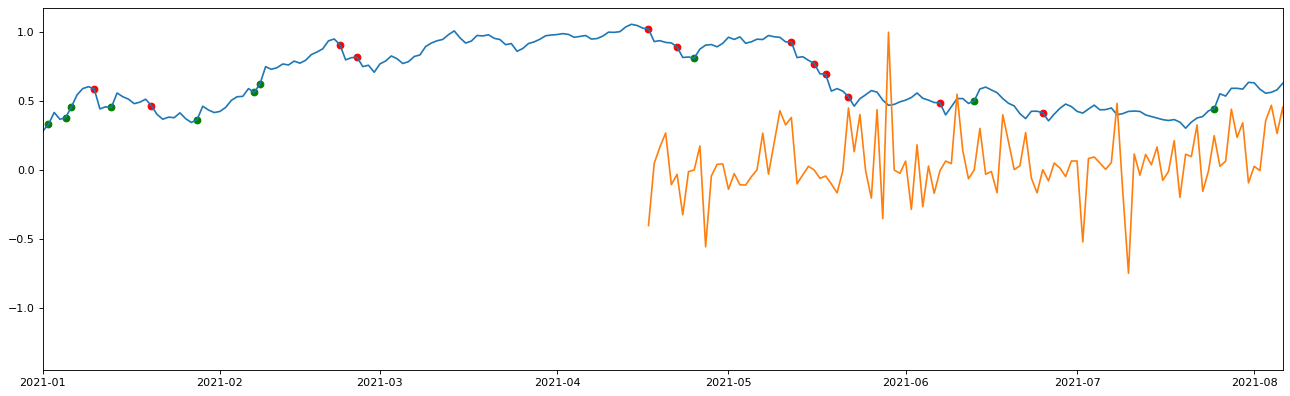

/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


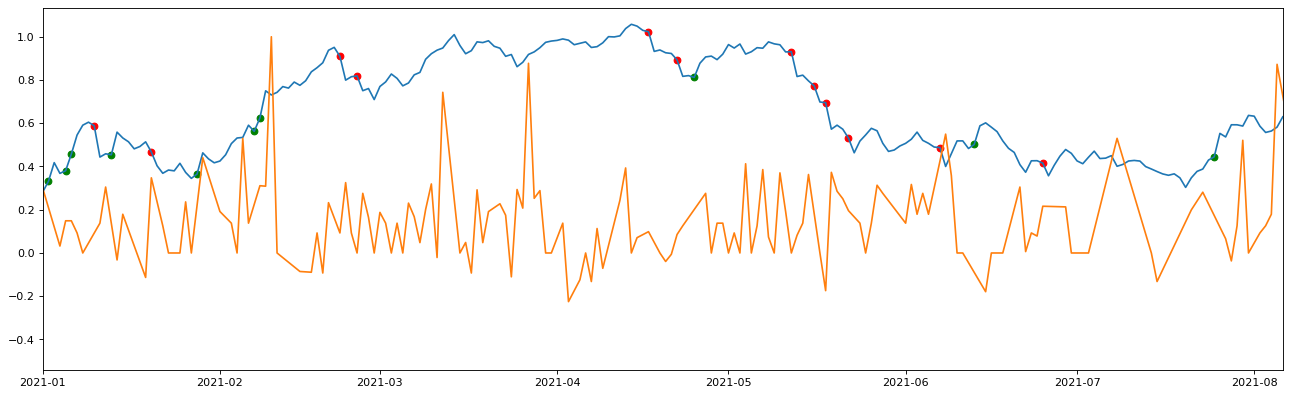

/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


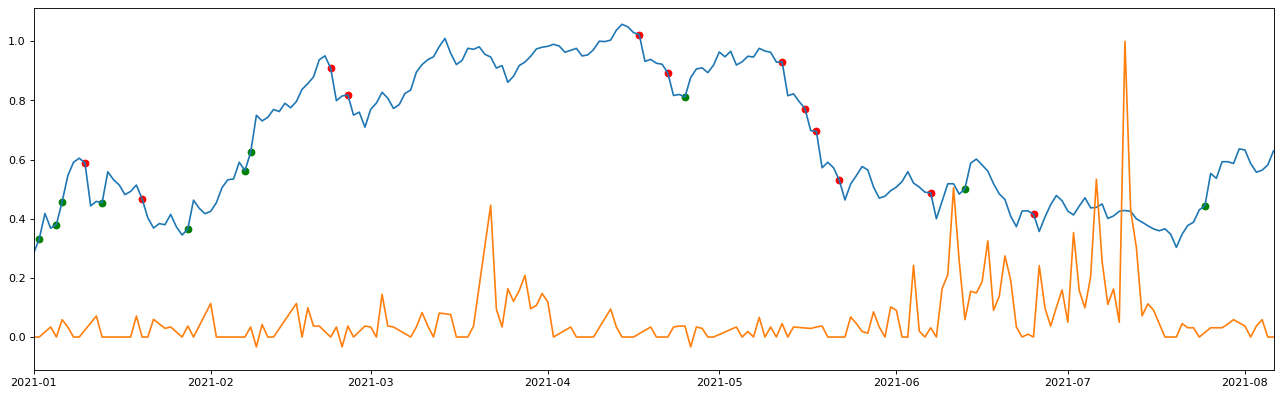

In [129]:

for user in list_of_users:
    user_tweets = all_tweets_g[all_tweets_g['username'] == user]
    user_tweets.compound_x = user_tweets.compound_x /user_tweets.compound_x.max()
    figure(figsize=(20, 6), dpi=80)
    plt.scatter(ts.index, delta_fall['heavy'], c='r')
    plt.scatter(ts.index, delta_rise['heavy'], c='g')
    plt.plot(ts.index, ts.price)
    plt.xlim((ts.index[0], ts.index[-1]))
    plt.plot(user_tweets.created_at, user_tweets.compound_x) 
    plt.show()

In [127]:
tweets_filtered

,username,created_at,compound_x,follower_count,compound_y
539,AirdropStar,2021-05-16,1.0513,855243.0,0.194658
544,AirdropStar,2021-05-21,0.6369,855243.0,0.194658
558,AirdropStar,2021-06-04,0.9200,855243.0,0.194658
604,AirdropStar,2021-07-22,0.7189,855243.0,0.194658
605,AirdropStar,2021-07-23,1.3721,855243.0,0.194658
807,Allen Au 🧢,2021-05-09,12.6679,42169.0,2.513104
808,Allen Au 🧢,2021-05-10,8.9709,42169.0,2.513104
1202,AquaGoat,2021-05-11,9.7235,94368.0,3.214109
1210,AquaGoat,2021-05-19,10.2056,94368.0,3.214109
1275,AquaGoat,2021-07-23,10.9965,94368.0,3.214109


In [128]:
list_of_users

array(['AirdropStar', 'Allen Au 🧢', 'AquaGoat', 'Ash WSB 🍥', 'Axion',
       'BITCOIN EXPERT INDIA', 'Bitcoin', 'Capital FM Uganda', 'Gagosian',
       'Nazionale Italiana ⭐️⭐️⭐️⭐️'], dtype=object)

### Granger Causality testing to asses if these accounts can predict Bitcoin Prices

In [273]:
ts = ts_class

In [274]:
# get all tweets users
users = all_tweets.username.unique()
users

array(['Bitcoin', 'Capital FM Uganda', 'Gagosian', 'Airdrop Inspector',
       'AirdropStar', 'Allen Au 🧢', 'Altcoin Daily', 'AquaGoat',
       'Ash WSB 🍥', 'Axion', 'Nazionale Italiana ⭐️⭐️⭐️⭐️',
       'BITCOIN EXPERT INDIA', '仮想NISHI'], dtype=object)

In [281]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

def compute_mse(ts, exog):
    exog = exog.reindex(ts.index).fillna(exog.compound.mean())

    mod = AutoReg(ts, 6, exog=exog,old_names=False)
    #mod = AutoReg(ts, 6,old_names=False)

    res = mod.fit()
    print(res.summary())
    pred = res.predict()
    pred = pred.to_frame()
    print(exog)
    def mse(df):
        return (df.price - df[0])**2

    joined = ts.join(pred)
    joined['mse'] = joined.apply(mse, axis=1)
    return joined.sum().mse
    

In [282]:
ts

,price
open_time,
2021-01-01,31480.538660
2021-01-02,31480.538660
2021-01-03,31480.538660
2021-01-04,31480.538660
2021-01-05,31480.538660
...,...
2021-08-02,40427.306143
2021-08-03,40149.829682
2021-08-04,39969.854607


In [283]:
from statsmodels.tsa.stattools import grangercausalitytests

f_test_res = []
for user in users:
    print(user)
    user_tweets = all_tweets[all_tweets.username==user]
    user_ts = user_tweets[['created_at', 'compound']]
    user_ts = user_ts.set_index('created_at')
    user_ts = user_ts.groupby('created_at').mean()
    user_ts = user_ts.loc[user_ts.index >= ts.index[0]]
    user_ts = user_ts.loc[user_ts.index <= ts.index[-1]]
    
    
    mse = compute_mse(ts, user_ts)
    merge = ts.join(user_ts)
    merge = merge.fillna(merge.compound.mean())
    gc_res = grangercausalitytests(merge, 6)
    
    f_test_res.append([user,gc_res[6][0]['ssr_ftest'], mse/ts.shape[0]])
    #print(gc_res)
print(merge)

Bitcoin
                            AutoReg Model Results                             
Dep. Variable:                  price   No. Observations:                  218
Model:                   AutoReg-X(6)   Log Likelihood               -1579.802
Method:               Conditional MLE   S.D. of innovations            416.947
Date:                Sat, 08 Jan 2022   AIC                             12.151
Time:                        06:51:46   BIC                             12.293
Sample:                    01-07-2021   HQIC                            12.208
                         - 08-06-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        171.4501    133.841      1.281      0.200     -90.873     433.773
price.L1       1.8848      0.067     28.328      0.000       1.754       2.015
price.L2      -0.8265      0.143     -5.790 

/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'




Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.2423  , p=0.0410  , df_denom=211, df_num=2
ssr based chi2 test:   chi2=6.6382  , p=0.0362  , df=2
likelihood ratio test: chi2=6.5382  , p=0.0380  , df=2
parameter F test:         F=3.2423  , p=0.0410  , df_denom=211, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8294  , p=0.0395  , df_denom=208, df_num=3
ssr based chi2 test:   chi2=8.7740  , p=0.0325  , df=3
likelihood ratio test: chi2=8.5997  , p=0.0351  , df=3
parameter F test:         F=2.8294  , p=0.0395  , df_denom=208, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.6354  , p=0.1666  , df_denom=205, df_num=4
ssr based chi2 test:   chi2=6.8289  , p=0.1452  , df=4
likelihood ratio test: chi2=6.7222  , p=0.1513  , df=4
parameter F test:         F=1.6354  , p=0.1666  , df_denom=205, df_num=4

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.3219  , p=0.2562 

/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'




Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2115  , p=0.6460  , df_denom=214, df_num=1
ssr based chi2 test:   chi2=0.2145  , p=0.6433  , df=1
likelihood ratio test: chi2=0.2144  , p=0.6433  , df=1
parameter F test:         F=0.2115  , p=0.6460  , df_denom=214, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4697  , p=0.6258  , df_denom=211, df_num=2
ssr based chi2 test:   chi2=0.9616  , p=0.6183  , df=2
likelihood ratio test: chi2=0.9595  , p=0.6189  , df=2
parameter F test:         F=0.4697  , p=0.6258  , df_denom=211, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2295  , p=0.8758  , df_denom=208, df_num=3
ssr based chi2 test:   chi2=0.7118  , p=0.8704  , df=3
likelihood ratio test: chi2=0.7106  , p=0.8707  , df=3
parameter F test:         F=0.2295  , p=0.8758  , df_denom=208, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.1847  , p=0.9462 

/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/dimmehal/anaconda3/envs/adaexam/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


parameter F test:         F=0.9939  , p=0.4306  , df_denom=199, df_num=6
BITCOIN EXPERT INDIA
                            AutoReg Model Results                             
Dep. Variable:                  price   No. Observations:                  218
Model:                   AutoReg-X(6)   Log Likelihood               -1580.455
Method:               Conditional MLE   S.D. of innovations            418.233
Date:                Sat, 08 Jan 2022   AIC                             12.157
Time:                        06:51:47   BIC                             12.299
Sample:                    01-07-2021   HQIC                            12.215
                         - 08-06-2021                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        159.1007    142.666      1.115      0.265    -120.519     438.721
price.L1       1.8818      0.067     

MissingDataError: exog contains inf or nans

In [284]:
for item in f_test_res:
    print("%s,%s,%s,%s"%(item[0],item[1][0], item[1][1], item[2]))


Bitcoin,0.2500017242130087,0.9588713900048591,169059.87136840468
Capital FM Uganda,0.7088988890139928,0.6427966162395244,169079.55477699926
Gagosian,0.6643054939857119,0.6785836929001772,169531.85601398663
Airdrop Inspector,1.7815103137391355,0.10454775668940959,168982.9806699113
AirdropStar,1.4693912456071287,0.19038991034217806,169989.99385897364
Allen Au 🧢,1.0368838371044933,0.4025455423787777,169547.9433973176
Altcoin Daily,0.6736159593601463,0.6710991775254296,170180.90137861567
AquaGoat,0.2608635100359181,0.9543814845298062,169626.36984973945
Ash WSB 🍥,0.6123134412477901,0.7203192468327931,169776.84589394633
Axion,1.207915746597609,0.30365689886428326,170186.9111263365
Nazionale Italiana ⭐️⭐️⭐️⭐️,0.9939141972555554,0.43055723453002237,168301.65940310355
BITCOIN EXPERT INDIA,1.4694226996629434,0.19037880503293225,170104.52849111357
